In [1]:
import os
import sys


import h5py
import numpy as np
import pandas as pd

In [2]:
import tqdm
from itertools import compress

In [3]:
from scipy import stats

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from joblib import Parallel, delayed

In [6]:
from scipy.stats import mannwhitneyu

# Get the data

In [9]:
path_metadata = '/data/longterm/10/athira/paper_tierpsy_behavior_v0/metadata/20210209_metadata_1743_of_4086_exps.pickle'

In [10]:
df_metadata = pd.read_pickle(path_metadata)

In [12]:
df_features = pd.read_pickle('/data/longterm/10/athira/Aug06_features_combined_LightStimuli.pickle')

In [13]:
df_features.reset_index(drop=True, inplace=True)
df_features

,frames,filename,drug,light,stimuli_name,stim_stat,curv_head,speed_x_head,speed_y_head,speed_head,...,rel_tan_tail_mid,rel_tan_tail_post_mid,rel_tan_tail_tip,ects_1,ects_2,ects_3,ects_4,ects_5,ects_6,quirkness
0,3,20181127_143624_1_5m0s_None_None_Light_INVERTE...,None,Light,blue,None,0.008654,1.582837,2.200000,2.710235,...,-0.055816,-1.220291,-0.991026,-0.321520,0.018623,0.525497,-0.204462,-0.499783,-0.542985,0.972898
1,8,20181127_143624_1_5m0s_None_None_Light_INVERTE...,None,Light,blue,None,0.051312,1.800598,2.471887,3.058166,...,0.307064,0.317399,-0.693456,-0.082744,0.133616,0.350841,-0.005826,-0.105237,-0.124100,0.994009
2,10,20181127_143624_1_5m0s_None_None_Light_INVERTE...,None,Light,blue,None,0.056092,-0.451324,3.500000,3.528979,...,0.452221,-0.002819,-1.021597,-0.208659,0.072926,0.753669,0.053136,-0.136477,-0.214775,0.986694
3,13,20181127_143624_1_5m0s_None_None_Light_INVERTE...,None,Light,blue,None,0.024868,-0.392069,1.948385,1.987441,...,0.074405,-0.634982,-0.864202,-0.120323,0.124137,0.287274,-0.088146,-0.078393,-0.123716,0.989737
4,15,20181127_143624_1_5m0s_None_None_Light_INVERTE...,None,Light,blue,None,0.024588,-4.324158,2.175842,4.840726,...,-0.412989,-1.383368,-0.355646,-0.286930,-0.214633,-0.065735,-0.568612,-0.389495,-0.259088,0.974992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976212,5100,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,None,0.001274,0.000000,-0.164215,0.164215,...,-0.301561,-0.236044,-0.396025,-0.020728,0.015803,-0.005523,0.006373,0.001200,0.001511,0.998556
976213,5101,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,None,0.001464,0.000000,0.030334,0.030334,...,-0.263721,-0.236688,-0.400613,-0.022885,0.018265,-0.001320,0.009915,0.009163,-0.003717,0.998536
976214,5102,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,None,-0.004669,-0.630402,0.041504,0.631766,...,-0.287359,-0.287359,-0.399611,-0.018111,0.032369,-0.025946,-0.001572,0.007484,-0.008369,0.998268
976215,5103,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,None,-0.000414,0.630402,0.731262,0.965479,...,-0.219792,-0.219793,-0.301602,-0.022867,0.021151,-0.008586,0.010159,0.009890,-0.002775,0.998546


In [14]:
df_features_combined = pd.merge(df_features, df_metadata[['filename','light_150']], left_on=['filename'], right_on=['filename'],
        left_index=True, how='left' )

In [15]:
df_light = df_features_combined[(df_features_combined['light_150'] == True)]

In [16]:
print(f'Total number of frames in the light dataset:  {len(df_light.index)}')

Total number of frames in the light dataset:  773256


In [17]:
print(f'Total number of experiments in the light dataset:  {len(list(df_light.filename.unique()))}')

Total number of experiments in the light dataset:  150


In [27]:
# Control is defined as the regions/frames where there is no light stimulus
df_light_control = df_light[(df_light['stim_stat']=='None')|(df_light['stim_stat']=='tONbefore')|(df_light['stim_stat']=='tOFFafter')]
# Also, control should not have drugs, I believe
df_light_control = df_light_control[df_light_control['drug']=='None']

print(f'Total number of frames in the control subset:  {len(df_light_control.index)}')
assert(len(list(df_light_control.filename.unique())) <= len(list(df_light.filename.unique())))

Total number of frames in the control subset:  462326


In [18]:
# For test 1, we compare the effect of switching ON or OFF the light. 
df_light_roi = df_light[df_light['stim_stat']!='None']
# Also, for test 1, I guess, we consider only no drug cases
df_light_roi = df_light_roi[df_light_roi['drug']=='None']

print(f'Total number of frames in the test1 subset:  {len(df_light_roi.index)}')
print(f'Total number of experiments in the test1 subset:  {len(list(df_light_roi.filename.unique()))}')
assert(len(list(df_light_roi.filename.unique())) <= len(list(df_light.filename.unique())))

Total number of frames in the test1 subset:  62848
Total number of experiments in the test1 subset:  101


In [19]:
# For test 1, we compare the effect of switching ON or OFF the light. 
df_light_drugs = df_light[df_light['stim_stat']=='tOFFafter']

print(f'Total number of frames in the test2 subset:  {len(df_light_drugs.index)}')
print(f'Total number of experiments in the test2 subset:  {len(list(df_light_drugs.filename.unique()))}')
assert(len(list(df_light_drugs.filename.unique())) <= len(list(df_light.filename.unique())))

Total number of frames in the test2 subset:  8325
Total number of experiments in the test2 subset:  113


Now this is interesting, if there are 150 experiments in the selected dataset, how come there are only 113 experimetns in the drug subset. This means that for the remaining **37 experiments**, there are no tOFFafter regions ! nans ? missing ??

In [20]:
params_list = df_light.columns.to_list()

In [21]:
speed_xys = ['speed_x_head', 'speed_y_head','speed_x_neck', 'speed_y_neck','speed_x_tail_base', 'speed_y_tail_base',
 'speed_x_tail_pre_mid', 'speed_y_tail_pre_mid','speed_x_tail_mid', 'speed_y_tail_mid',
 'speed_x_tail_post_mid', 'speed_y_tail_post_mid','speed_x_tail_tip', 'speed_y_tail_tip']
for sp_ in speed_xys:
    params_list.remove(sp_)

In [22]:
params_list.remove('light_150')

In [23]:
params_list.remove('frames')
params_list.remove('filename')
params_list.remove('drug')
params_list.remove('light')
params_list.remove('stimuli_name')
params_list.remove('stim_stat')
print(params_list)

['curv_head', 'speed_head', 'tan_head', 'angvel_head', 'curv_neck', 'speed_neck', 'tan_neck', 'angvel_neck', 'curv_tail_base', 'speed_tail_base', 'tan_tail_base', 'angvel_tail_base', 'curv_tail_pre_mid', 'speed_tail_pre_mid', 'tan_tail_pre_mid', 'angvel_tail_pre_mid', 'curv_tail_mid', 'speed_tail_mid', 'tan_tail_mid', 'angvel_tail_mid', 'curv_tail_post_mid', 'speed_tail_post_mid', 'tan_tail_post_mid', 'angvel_tail_post_mid', 'curv_tail_tip', 'speed_tail_tip', 'tan_tail_tip', 'angvel_tail_tip', 'rel_tan_neck', 'rel_tan_tail_base', 'rel_tan_tail_pre_mid', 'rel_tan_tail_mid', 'rel_tan_tail_post_mid', 'rel_tan_tail_tip', 'ects_1', 'ects_2', 'ects_3', 'ects_4', 'ects_5', 'ects_6', 'quirkness']


In [ ]:
df_light_roi.stim_stat.unique()

In [ ]:
df_light_control.stim_stat.unique()

In [ ]:
df_light_drugs.stim_stat.unique()

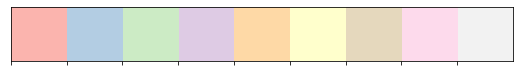

In [24]:
cpal = sns.color_palette("Pastel1",9)
sns.palplot(cpal)

In [25]:
color_dict = {'white':cpal[-1], 'red':cpal[0], 'blue':cpal[1], 'green':cpal[2]}

In [28]:
stim_order = list(df_light_control.stimuli_name.unique())
stim_color_order = [color_dict[x] for x in stim_order]

# Plots - control 

In [ ]:
df_light_control.stimuli_name.unique()

In [ ]:
feat_names_dict = {'curv':'Curvature', 'speed': 'Speed', 'rel_tan': 'Relative_Tangent_Angles'}

In [ ]:
for stim in list(df_light_control.stimuli_name.unique()):
    
    fig, axes = plt.subplots(1,3, figsize = (24, 10))
    df_stim = df_light_control[df_light_control['stimuli_name'] == stim]

    for i, feat in tqdm.tqdm(enumerate(['curv', 'speed', 'rel_tan'])):


        df_feat_control = df_stim.filter(items = [f"{feat}_neck",f"{feat}_tail_base", f"{feat}_tail_pre_mid",
                                                    f"{feat}_tail_mid", f"{feat}_tail_post_mid", f"{feat}_tail_tip"])
        df_feat_control_zf = df_stim[(np.abs(stats.zscore(df_feat_control)) < 3).all(axis=1)] 
        df_feat_control_zf = df_feat_control_zf.filter(items = [f"{feat}_neck",f"{feat}_tail_base", f"{feat}_tail_pre_mid",
                                                    f"{feat}_tail_mid", f"{feat}_tail_post_mid", f"{feat}_tail_tip"])

        col_rename_dict = {f"{feat}_neck" : "neck",
                           f"{feat}_tail_base" :"tail_base", 
                           f"{feat}_tail_pre_mid" : "tail_pre_mid",      
                           f"{feat}_tail_mid": "tail_mid", 
                           f"{feat}_tail_post_mid": "tail_post_mid", 
                           f"{feat}_tail_tip": "tail_tail_tip"}

        df_feat_control_zf.rename(columns= col_rename_dict, inplace=True)
#         df_melted = pd.melt(df_feat_control_zf, var_name= 'segment', value_name= feat)

        with sns.axes_style("darkgrid"):
                
            if 'speed' in feat:    
                sns.violinplot(data = df_feat_control_zf, ax=axes[i], color= color_dict[stim], cut=0)
            else: 
                sns.violinplot(data = df_feat_control_zf, ax=axes[i], color= color_dict[stim])
                
            axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation=30, size = 'x-large')
            axes[i].set_ylabel(feat_names_dict[feat], size = 'xx-large')
    plt.suptitle(f'Control statitics for {stim} light', size = 'xx-large', fontweight = 'bold')  
    fig.savefig(f'./Figures/stats_light/stats_light_control/control_{stim}_1a.svg')

In [ ]:
for stim in list(df_light_control.stimuli_name.unique()):
    
    df_stim = df_light_control[df_light_control['stimuli_name'] == stim]
    df_feat_control = df_stim.filter(like='ects_')
    df_feat_control_zf = df_stim[(np.abs(stats.zscore(df_feat_control)) < 3).all(axis=1)] 
    df_feat_control_zf = df_feat_control_zf.filter(like='ects_')

    df_melted = pd.melt(df_feat_control_zf, var_name= 'coeff', value_name= 'ects')
#     with sns.axes_style("darkgrid"):
    fig, ax2 = plt.subplots(1,1, figsize = (15, 10))
    sns.violinplot(data = df_melted, x = 'coeff', y= 'ects', ax=ax2, color= color_dict[stim])
    ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30, size = 'x-large')
    ax2.set_ylabel('Eigen cofficient value', size = 'xx-large')
    ax2.set_xlabel('Coefficient', size = 'x-large')
    ax2.set_title(f'Control statitics for {stim} light', size = 'xx-large', fontweight = 'bold')
    fig.savefig(f'./Figures/stats_light/stats_light_control/control_{stim}_1b.svg')

In [ ]:
for stim in list(df_light_control.stimuli_name.unique()):
    
    df_stim = df_light_control[df_light_control['stimuli_name'] == stim]
    df_feat_control = df_stim.filter(like='quirkness')
    df_feat_control_zf = df_stim[(np.abs(stats.zscore(df_feat_control)) < 3).all(axis=1)] 
    df_feat_control_zf = df_feat_control_zf.filter(like='quirkness')

    # with sns.axes_style("darkgrid"):
    fig, ax3 = plt.subplots(1,1, figsize = (8, 10))
    sns.violinplot(data = df_feat_control_zf, color= color_dict[stim], ax = ax3 )
    ax3.set_xticklabels(ax3.get_xticklabels(),rotation=30)
    ax3.set_ylabel('Quirkiness', size = 'xx-large')
    ax3.axes.xaxis.set_visible(False)
    ax3.set_title(f'Control statitics for {stim} light', size = 'xx-large', fontweight = 'bold')
    fig.savefig(f'./Figures/stats_light/stats_light_control/control_{stim}_1c.svg')

In [ ]:
df_light_control.columns

In [ ]:

ax = sns.countplot(data = df_light_control, x = 'stimuli_name', order = stim_order, palette= stim_color_order)
ax.set_ylabel('Number of frames')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), 
                   textcoords = 'offset points')
ax.set_title('Number of frames(samples) in the \n control dataset for light experiments')
plt.savefig(f'./Figures/stats_light/stats_light_control/control_frames_ref.svg')

# Test 1 : Effect of switching 

In [61]:
dest_folder_oct18 = '/data/temp/athira/oct18_violinplots_rescaled/light_plots/'

In [29]:
stim_order

['red', 'blue', 'green', 'white']

Text(0.5, 1.0, 'Number of frames(samples) in the \n dataset for test1')

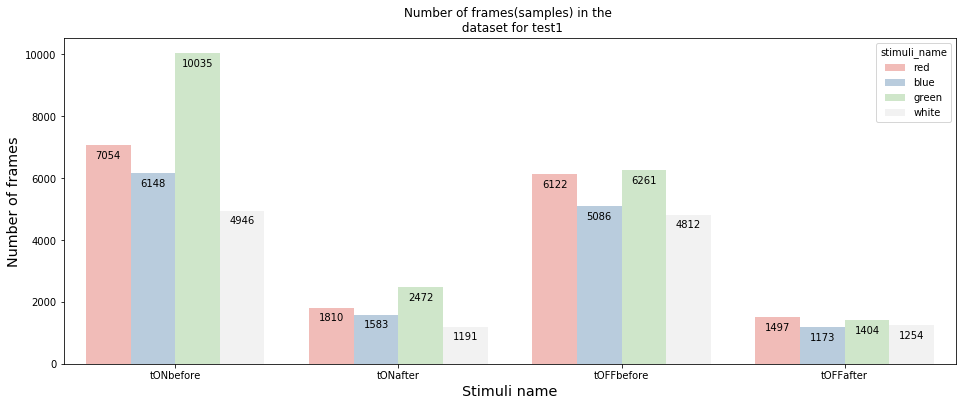

In [31]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(data = df_light_roi, x = 'stim_stat', hue = 'stimuli_name', hue_order= stim_order, 
                   palette=stim_color_order)
ax.set_ylabel('Number of frames', size = 'x-large')
ax.set_xlabel('Stimuli name', size = 'x-large')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -10), 
                   textcoords = 'offset points')
ax.set_title('Number of frames(samples) in the \n dataset for test1')
# plt.savefig(os.path.join(dest_folder_oct18, 'test1_frames_ref.svg'))

## mannwhitney tests

In [ ]:
# params_list

In [32]:
def mannwhitney_test1(stim_stat, stimuli_name, params_list, _tail):
    
    pvalues_dict = {}
    pvalues_dict['stimuli_name'] = stimuli_name
    pvalues_dict['switch'] = stim_stat[:3]
    
    df = df_light_roi[(df_light_roi['stimuli_name'] == stimuli_name)]
    
    if stim_stat == 'tONafter':
        control = 'tONbefore'
    else:
        control = 'tOFFbefore'
    
    for param in params_list:
        
        
        results = mannwhitneyu(*[df[param][df["stim_stat"] == group].values 
                         for group in [control,stim_stat]], alternative= _tail)
        pvalues_dict[param] = results[-1]

    return pvalues_dict

In [33]:
df_pval_stims_test1 = []

for stim in tqdm.tqdm(stim_order): 
    
    mwu_stim_test1 = Parallel(n_jobs=2, verbose = 5)(delayed(mannwhitney_test1)(stim_stat, stim, params_list,'two-sided') 
                                                          for stim_stat in ['tONafter', 'tOFFafter'])
    df_pval_mwu_stim_test1 = pd.DataFrame(mwu_stim_test1)
    df_pval_stims_test1.append(df_pval_mwu_stim_test1)

df_pval_mwu_test1 = pd.concat(df_pval_stims_test1)

  0%|          | 0/4 [00:00<?, ?it/s][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
 25%|██▌       | 1/4 [00:01<00:04,  1.34s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
 50%|█████     | 2/4 [00:01<00:01,  1.02it/s][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
 75%|███████▌  | 3/4 [00:01<00:00,  1.34it/s][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0

In [34]:
df_pval_mwu_test1

,stimuli_name,switch,curv_head,speed_head,tan_head,angvel_head,curv_neck,speed_neck,tan_neck,angvel_neck,...,rel_tan_tail_mid,rel_tan_tail_post_mid,rel_tan_tail_tip,ects_1,ects_2,ects_3,ects_4,ects_5,ects_6,quirkness
0,red,tON,1.904131e-01,9.150619e-06,6.827884e-02,0.852806,6.457827e-08,4.573387e-03,7.742695e-05,0.835055,...,0.586487,0.700035,0.086932,0.000389,3.102377e-03,1.272542e-02,7.262635e-01,0.032457,3.950100e-01,2.687466e-01
1,red,tOF,2.564008e-10,1.424059e-10,9.950848e-18,0.873963,1.883293e-01,6.858868e-21,4.548311e-20,0.698930,...,0.001603,0.003758,0.000964,0.675296,1.449022e-11,1.460654e-03,7.896279e-03,0.486696,4.509978e-09,8.102734e-04
0,blue,tON,2.237870e-01,1.289329e-08,6.122598e-01,0.921029,6.200686e-01,7.817749e-06,5.898609e-01,0.886585,...,0.090388,0.169064,0.011290,0.053179,6.275782e-03,2.938092e-02,2.150501e-02,0.109336,3.996334e-02,2.418406e-04
1,blue,tOF,1.712359e-03,2.654242e-19,4.940514e-03,0.382082,4.297650e-03,2.465357e-05,7.062700e-03,0.619069,...,0.890674,0.005536,0.002357,0.002032,9.446587e-01,2.292916e-08,1.337656e-03,0.630569,2.587195e-04,1.371076e-09
0,green,tON,1.242317e-05,4.447729e-10,1.389928e-01,0.796085,2.365968e-02,1.455147e-07,2.595735e-02,0.813173,...,0.018328,0.038013,0.142228,0.150933,1.793513e-05,9.178789e-03,2.082152e-01,0.012628,1.838526e-02,2.989636e-03
1,green,tOF,2.033257e-02,1.470061e-09,7.142227e-11,0.837766,6.703153e-04,2.258766e-05,4.622462e-09,0.611103,...,0.977207,0.377235,0.697959,0.685715,2.357613e-01,2.124981e-01,1.326314e-13,0.000940,2.517116e-01,4.116974e-14
0,white,tON,5.034363e-04,1.210562e-03,3.587763e-09,0.464420,7.092887e-02,6.736960e-04,2.824458e-07,0.586804,...,0.002056,0.005140,0.033521,0.974908,6.141187e-01,3.711834e-05,1.012315e-01,0.021353,1.384454e-09,6.687121e-01
1,white,tOF,1.541437e-02,3.580455e-07,7.720845e-01,0.977944,1.447779e-01,3.852002e-10,1.506469e-01,0.965965,...,0.001871,0.049628,0.111861,0.009851,7.676701e-01,1.059111e-02,7.239414e-01,0.323187,1.144371e-04,3.862621e-20


In [35]:
df_pval_mwu_test1.set_index(['stimuli_name','switch'], inplace = True)
df_pval_mwu_test1

curv_head    speed_head      tan_head  angvel_head  \
stimuli_name switch                                                          
red          tON     1.904131e-01  9.150619e-06  6.827884e-02     0.852806   
             tOF     2.564008e-10  1.424059e-10  9.950848e-18     0.873963   
blue         tON     2.237870e-01  1.289329e-08  6.122598e-01     0.921029   
             tOF     1.712359e-03  2.654242e-19  4.940514e-03     0.382082   
green        tON     1.242317e-05  4.447729e-10  1.389928e-01     0.796085   
             tOF     2.033257e-02  1.470061e-09  7.142227e-11     0.837766   
white        tON     5.034363e-04  1.210562e-03  3.587763e-09     0.464420   
             tOF     1.541437e-02  3.580455e-07  7.720845e-01     0.977944   

                        curv_neck    speed_neck      tan_neck  angvel_neck  \
stimuli_name switch                                                          
red          tON     6.457827e-08  4.573387e-03  7.742695e-05     0.835055   
             tOF     1.883293e-01  6.858868e-21  4.548311e-20     0.698930   
blue         tON     6.200686e-01  7.817749e-06  5.898609e-01     0.886585   
             tOF     4.297650e-03  2.465357e-05  7.062700e-03     0.619069   
green        tON     2.365968e-02  1.455147e-07  2.595735e-02     0.813173   
             tOF     6.703153e-04  2.258766e-05  4.622462e-09     0.611103   
white        tON     7.092887e-02  6.736960e-04  2.824458e-07     0.586804   
             tOF     1.447779e-01  3.852002e-10  1.506469e-01     0.965965   

                     curv_tail_base  speed_tail_base  ...  rel_tan_tail_mid  \
stimuli_name switch                                   ...                     
red          tON           0.000033     2.859806e-03  ...          0.586487   
             tOF           0.845293     9.185986e-21  ...          0.001603   
blue         tON           0.022126     5.658326e-09  ...          0.090388   
             tOF           0.001496     2.487255e-07  ...          0.890674   
green        tON           0.404496     1.396519e-04  ...          0.018328   
             tOF           0.004821     2.801544e-06  ...          0.977207   
white        tON           0.937148     8.553400e-04  ...          0.002056   
             tOF           0.010574     7.934799e-14  ...          0.001871   

                     rel_tan_tail_post_mid  rel_tan_tail_tip    ects_1  \
stimuli_name switch                                                      
red          tON                  0.700035          0.086932  0.000389   
             tOF                  0.003758          0.000964  0.675296   
blue         tON                  0.169064          0.011290  0.053179   
             tOF                  0.005536          0.002357  0.002032   
green        tON                  0.038013          0.142228  0.150933   
             tOF                  0.377235          0.697959  0.685715   
white        tON                  0.005140          0.033521  0.974908   
             tOF                  0.049628          0.111861  0.009851   

                           ects_2        ects_3        ects_4    ects_5  \
stimuli_name switch                                                       
red          tON     3.102377e-03  1.272542e-02  7.262635e-01  0.032457   
             tOF     1.449022e-11  1.460654e-03  7.896279e-03  0.486696   
blue         tON     6.275782e-03  2.938092e-02  2.150501e-02  0.109336   
             tOF     9.446587e-01  2.292916e-08  1.337656e-03  0.630569   
green        tON     1.793513e-05  9.178789e-03  2.082152e-01  0.012628   
             tOF     2.357613e-01  2.124981e-01  1.326314e-13  0.000940   
white        tON     6.141187e-01  3.711834e-05  1.012315e-01  0.021353   
             tOF     7.676701e-01  1.059111e-02  7.239414e-01  0.323187   

                           ects_6     quirkness  
stimuli_name switch                              
red          tON     3.950100e-01  2.687466e-01  
             tOF     4.509978

In [36]:
df_pval_mwu_test1.index

MultiIndex([(  'red', 'tON'),
            (  'red', 'tOF'),
            ( 'blue', 'tON'),
            ( 'blue', 'tOF'),
            ('green', 'tON'),
            ('green', 'tOF'),
            ('white', 'tON'),
            ('white', 'tOF')],
           names=['stimuli_name', 'switch'])

In [37]:
df_binary_none = df_pval_mwu_test1[params_list] < 0.05

In [38]:
df_binary_none 

curv_head  speed_head  tan_head  angvel_head  curv_neck  \
stimuli_name switch                                                            
red          tON         False        True     False        False       True   
             tOF          True        True      True        False      False   
blue         tON         False        True     False        False      False   
             tOF          True        True      True        False       True   
green        tON          True        True     False        False       True   
             tOF          True        True      True        False       True   
white        tON          True        True      True        False      False   
             tOF          True        True     False        False      False   

                     speed_neck  tan_neck  angvel_neck  curv_tail_base  \
stimuli_name switch                                                      
red          tON           True      True        False            True   
             tOF           True      True        False           False   
blue         tON           True     False        False            True   
             tOF           True      True        False            True   
green        tON           True      True        False           False   
             tOF           True      True        False            True   
white        tON           True      True        False           False   
             tOF           True     False        False            True   

                     speed_tail_base  ...  rel_tan_tail_mid  \
stimuli_name switch                   ...                     
red          tON                True  ...             False   
             tOF                True  ...              True   
blue         tON                True  ...             False   
             tOF                True  ...             False   
green        tON                True  ...              True   
             tOF                True  ...             False   
white        tON                True  ...              True   
             tOF                True  ...              True   

                     rel_tan_tail_post_mid  rel_tan_tail_tip  ects_1  ects_2  \
stimuli_name switch                                                            
red          tON                     False             False    True    True   
             tOF                      True              True   False    True   
blue         tON                     False              True   False    True   
             tOF                      True              True    True   False   
green        tON                      True             False   False    True   
             tOF                     False             False   False   False   
white        tON                      True              True   False   False   
             tOF                      True             False    True   False   

                     ects_3  ects_4  ects_5  ects_6  quirkness  
stimuli_name switch                                             
red          tON       True   False    True   False      False  
             tOF       True    True   False    True       True  
blue         tON       True    True   False    True       True  
             tOF       True    True   False    True       True  
green        tON       True   False    True    True       True  
             tOF      False    True    True   False       True  
white        tON       True   False    True    True      False  
             tOF       True   False   False    True       True  

[8 rows x 41 columns]

In [39]:
df_binary_test1 = df_binary_none 
# df_pval_mwu_test1.to_pickle('/share/devops/athira/ciona_tierpsy_behavior/Data/mwu_test_pvalues_light_test1.pickle')

In [ ]:
# def test_light_mannwhitney(stim_stat, stimuli_name, drug, params_list, _tail):
    
#     pvalues_dict = {}
#     pvalues_dict['drug'] = drug
#     pvalues_dict['stimuli_name'] = stimuli_name
#     pvalues_dict['switch'] = stim_stat[:3]
    
#     df = df_light_roi[(df_light_roi['drug'] == drug) & (df_light_roi['stimuli_name'] == stimuli_name)]
    
#     if stim_stat == 'tONafter':
#         control = 'tONbefore'
#     else:
#         control = 'tOFFbefore'
    
#     for param in params_list:
        
#         results = mannwhitneyu(*[df[param][df["stim_stat"] == group].values 
#                          for group in [control,stim_stat]], alternative= _tail)
        
#         pvalues_dict[param] = results[-1]
        
#     return pvalues_dict

In [ ]:
# mwu_blue_none = Parallel(n_jobs=2, verbose = 5)(delayed(test_light_mannwhitney)(stim_, 'blue', 'None', params_list,'two-sided') 
#                                                           for stim_ in ['tONafter', 'tOFFafter'])

In [ ]:
# mwu_white_none = Parallel(n_jobs=2, verbose = 5)(delayed(test_light_mannwhitney)(stim_, 'white', 'None', params_list,'two-sided') 
#                                                           for stim_ in ['tONafter', 'tOFFafter'])

In [ ]:
# mwu_red_none = Parallel(n_jobs=2, verbose = 5)(delayed(test_light_mannwhitney)(stim_, 'red', 'None', params_list,'two-sided') 
#                                                           for stim_ in ['tONafter', 'tOFFafter'])

In [ ]:
# mwu_green_none = Parallel(n_jobs=2, verbose = 5)(delayed(test_light_mannwhitney)(stim_, 'green', 'None', params_list,'two-sided') 
#                                                           for stim_ in ['tONafter', 'tOFFafter'])

In [ ]:
# df_pval_mwu_green_none = pd.DataFrame(mwu_green_none)
# df_pval_mwu_blue_none = pd.DataFrame(mwu_blue_none)
# df_pval_mwu_red_none = pd.DataFrame(mwu_red_none)
# df_pval_mwu_white_none = pd.DataFrame(mwu_white_none)


In [ ]:
# df_pval_mwu_none = pd.concat([df_pval_mwu_green_none,df_pval_mwu_blue_none,df_pval_mwu_red_none,df_pval_mwu_white_none])

In [ ]:
# df_pval_mwu_none 

In [ ]:
# df_pval_mwu_none.set_index(['stimuli_name','switch'], inplace = True)

In [ ]:
# df_pval_mwu_none.index

In [ ]:
# df_binary_none = df_pval_mwu_none[params_list] < 0.05

In [ ]:
# df_binary_none.loc[('green','tON')]['curv_head']

## make plots - test1

In [40]:
def get_zscores_test1(param):

    df_param = df_light_roi.groupby(['drug','stimuli_name','stim_stat'])[param].transform(lambda x: np.abs(stats.zscore(x, ddof=1)))
    
    return df_param

In [41]:
df_zscores_test1 = Parallel(n_jobs=30, verbose = 5)(delayed(get_zscores_test1)(param) for param in params_list)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   9 out of  41 | elapsed:    1.4s remaining:    5.1s
[Parallel(n_jobs=30)]: Done  18 out of  41 | elapsed:    1.6s remaining:    2.0s
[Parallel(n_jobs=30)]: Done  27 out of  41 | elapsed:    1.6s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  36 out of  41 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  41 out of  41 | elapsed:    1.9s finished


In [42]:
df_combined_zscores_test1 = pd.concat(df_zscores_test1, axis = 1, keys=[f'{df.name}_zscore' for df in df_zscores_test1])
df_combined_zscores_test1

,curv_head_zscore,speed_head_zscore,tan_head_zscore,angvel_head_zscore,curv_neck_zscore,speed_neck_zscore,tan_neck_zscore,angvel_neck_zscore,curv_tail_base_zscore,speed_tail_base_zscore,...,rel_tan_tail_mid_zscore,rel_tan_tail_post_mid_zscore,rel_tan_tail_tip_zscore,ects_1_zscore,ects_2_zscore,ects_3_zscore,ects_4_zscore,ects_5_zscore,ects_6_zscore,quirkness_zscore
130,0.928989,0.193312,0.234993,0.072429,0.470479,0.264752,0.405240,0.452453,1.137672,0.145555,...,0.672971,0.681976,0.688250,1.084220,0.681602,0.028428,0.328707,0.503184,0.239479,0.167530
130,0.709310,0.042615,0.232678,0.003914,0.592099,0.234424,0.284933,0.194247,1.316957,0.004258,...,0.649858,0.703216,0.694687,1.094228,0.481277,0.075938,0.519619,0.541983,0.228671,0.159269
130,1.071302,0.006443,0.212848,0.034884,0.767768,0.083117,0.210287,0.121090,1.301584,0.269052,...,0.653665,0.690862,0.652201,1.127142,0.925567,0.364406,0.651018,0.305092,0.247019,0.162469
130,1.179051,0.368643,0.208873,0.006850,0.893859,0.363167,0.301803,0.145129,1.315083,0.272153,...,0.667362,0.738476,0.731715,1.155687,0.898392,0.480534,0.735966,0.320180,0.097160,0.149446
130,0.991281,0.289461,0.231392,0.039998,0.740193,0.488062,0.402384,0.159652,1.403588,0.439492,...,0.639430,0.670153,0.711046,1.111888,0.898953,0.316213,0.604901,0.179315,0.429857,0.158358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,0.113320,0.775284,0.749448,0.041286,1.220111,0.672152,0.708559,0.106340,0.485635,0.810424,...,0.372917,0.428878,0.529583,0.637888,0.726285,0.018499,0.158869,0.098062,0.129842,0.387366
4069,0.156948,0.704843,0.747804,0.004715,1.003039,0.700950,0.643649,0.071651,0.379123,0.729913,...,0.399932,0.427033,0.515721,0.614885,0.508201,0.044730,0.154863,0.304044,0.268631,0.392587
4069,0.315041,0.658957,0.749044,0.008840,1.014576,0.603686,0.682674,0.057293,0.584809,0.729266,...,0.409342,0.421497,0.527736,0.633315,0.800001,0.026461,0.129572,0.087588,0.003861,0.386482
4069,0.051409,0.663832,0.750026,0.008471,0.999815,0.651155,0.614608,0.075567,0.493210,0.695594,...,0.396170,0.422305,0.493262,0.601934,0.351059,0.109453,0.075147,0.536906,0.147578,0.396877


In [43]:
df_light_zscores_test1 = pd.concat([df_light_roi,df_combined_zscores_test1], axis=1)

In [44]:
df_light_zscores_test1

,frames,filename,drug,light,stimuli_name,stim_stat,curv_head,speed_x_head,speed_y_head,speed_head,...,rel_tan_tail_mid_zscore,rel_tan_tail_post_mid_zscore,rel_tan_tail_tip_zscore,ects_1_zscore,ects_2_zscore,ects_3_zscore,ects_4_zscore,ects_5_zscore,ects_6_zscore,quirkness_zscore
130,601,20181205_164105_1_5m0s_None_None_Light_INVERTE...,None,Light,blue,tONbefore,0.023145,1.236145,-0.241211,1.259459,...,0.672971,0.681976,0.688250,1.084220,0.681602,0.028428,0.328707,0.503184,0.239479,0.167530
130,602,20181205_164105_1_5m0s_None_None_Light_INVERTE...,None,Light,blue,tONbefore,0.019367,-2.250488,1.000000,2.462661,...,0.649858,0.703216,0.694687,1.094228,0.481277,0.075938,0.519619,0.541983,0.228671,0.159269
130,603,20181205_164105_1_5m0s_None_None_Light_INVERTE...,None,Light,blue,tONbefore,0.025593,2.238831,-0.421631,2.278187,...,0.653665,0.690862,0.652201,1.127142,0.925567,0.364406,0.651018,0.305092,0.247019,0.162469
130,604,20181205_164105_1_5m0s_None_None_Light_INVERTE...,None,Light,blue,tONbefore,0.027447,0.258301,-0.258301,0.365292,...,0.667362,0.738476,0.731715,1.155687,0.898392,0.480534,0.735966,0.320180,0.097160,0.149446
130,605,20181205_164105_1_5m0s_None_None_Light_INVERTE...,None,Light,blue,tONbefore,0.024217,-0.713928,-0.286072,0.769110,...,0.639430,0.670153,0.711046,1.111888,0.898953,0.316213,0.604901,0.179315,0.429857,0.158358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,2786,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,tOFFafter,0.002188,0.000000,0.267609,0.267609,...,0.372917,0.428878,0.529583,0.637888,0.726285,0.018499,0.158869,0.098062,0.129842,0.387366
4069,2787,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,tOFFafter,0.001580,0.000000,-0.803162,0.803162,...,0.399932,0.427033,0.515721,0.614885,0.508201,0.044730,0.154863,0.304044,0.268631,0.392587
4069,2788,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,tOFFafter,-0.000623,1.000000,0.571991,1.152030,...,0.409342,0.421497,0.527736,0.633315,0.800001,0.026461,0.129572,0.087588,0.003861,0.386482
4069,2789,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,tOFFafter,0.003051,-1.000000,-0.493103,1.114967,...,0.396170,0.422305,0.493262,0.601934,0.351059,0.109453,0.075147,0.536906,0.147578,0.396877


In [46]:
def make_a_melted_df_test1(main_df, param, on_event = True):
    
    list_to_melt = []
    params_df = main_df.filter(items=['stimuli_name', 'stim_stat', param, f'{param}_zscore'])
    
    for stim_name in ['white','red','green','blue']:
        
        if on_event :
            pre = 'tONbefore'
            post = 'tONafter'
        else :
            pre = 'tOFFbefore'
            post = 'tOFFafter'
        
        switch = pre[:3]
        if df_binary_test1.loc[(stim_name, switch)][param]:
        
            # Select only those rows which are relevant to the particular light stimulus 
            stim_df = params_df[(params_df['stimuli_name']== stim_name)]
            # Select only those rows which are relevant to the particular light stimulus 
            stim_event_df = stim_df[(stim_df['stim_stat']==pre)|(stim_df['stim_stat']==post)]

            # Select those rows which have an acceptable zscore
            stim_event_df = stim_event_df[stim_event_df[f'{param}_zscore'] < 3]
            stim_event_df.drop(columns=f'{param}_zscore', inplace=True)


            list_to_melt.append(stim_event_df)
    
    if list_to_melt:
        melted_param_df = pd.concat(list_to_melt)
        return melted_param_df      
    else:
        return param

In [57]:
def get_melted_dfs_for_test1(param):
    
    param_dict = {} 
    param_dict['param'] = param
    
    
    melted_param_df_on = make_a_melted_df_test1(df_light_zscores_test1, param)
    melted_param_df_off = make_a_melted_df_test1(df_light_zscores_test1, param, on_event=False)
    
    if 'curv' in param :
        conv_by = 1/11.56
    elif 'speed'in param:
        conv_by = 346.80
    else :
        conv_by = 1
    if isinstance(melted_param_df_on, pd.DataFrame):
        melted_param_df_on[param] = melted_param_df_on[param] * conv_by
        
    if isinstance(melted_param_df_off, pd.DataFrame):
        melted_param_df_off[param] = melted_param_df_off[param] * conv_by
        
    param_dict['melted_on'] = melted_param_df_on
    param_dict['melted_off'] = melted_param_df_off
    return param_dict

In [58]:
# param_dict = get_melted_dfs_for_test1('curv_tail_base')

In [59]:
short_params_list =  ['curv_neck',
'speed_neck',
'curv_tail_base',
'speed_tail_base',
'curv_tail_pre_mid',
'speed_tail_pre_mid',
'curv_tail_mid',
'speed_tail_mid',
'curv_tail_post_mid',
'speed_tail_post_mid',
'curv_tail_tip',
'speed_tail_tip',
'rel_tan_neck',
'rel_tan_tail_base',
'rel_tan_tail_pre_mid',
'rel_tan_tail_mid',
'rel_tan_tail_post_mid',
'rel_tan_tail_tip',
'ects_1',
'ects_2',
'ects_3',
'ects_4',
'ects_5',
'ects_6',
'quirkness']

In [60]:
param_dict_list_test1 = Parallel(n_jobs= 30, verbose = 5)(delayed(get_melted_dfs_for_test1)(param) for param in short_params_list)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   2 out of  25 | elapsed:    1.4s remaining:   15.6s
[Parallel(n_jobs=30)]: Done   8 out of  25 | elapsed:    1.4s remaining:    3.0s
[Parallel(n_jobs=30)]: Done  14 out of  25 | elapsed:    1.7s remaining:    1.4s
[Parallel(n_jobs=30)]: Done  20 out of  25 | elapsed:    2.0s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  25 out of  25 | elapsed:    2.2s finished


19it [00:02, 10.13it/s]<ipython-input-62-6e9757aed5fa>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 1, figsize=(violin_height*(n_sub)/2,violin_height), sharey=True)
21it [00:02,  9.26it/s]<ipython-input-62-6e9757aed5fa>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 1, figsize=(violin_height*(n_sub)/2,violin_height), sharey=True)
<ipython-input-62-6e9757aed5fa>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

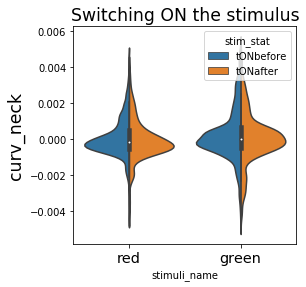

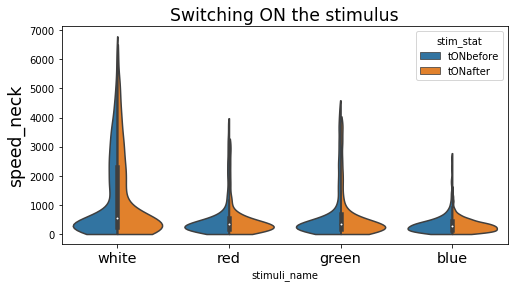

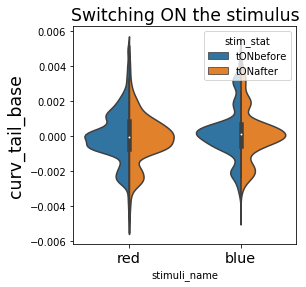

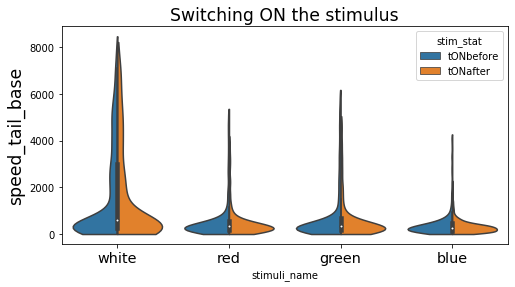

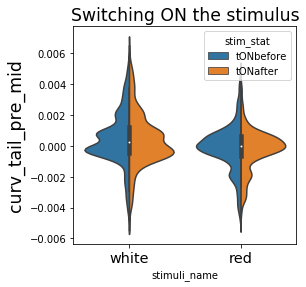

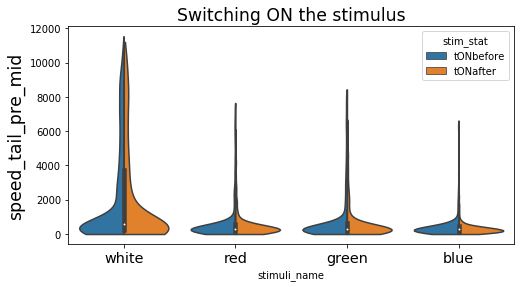

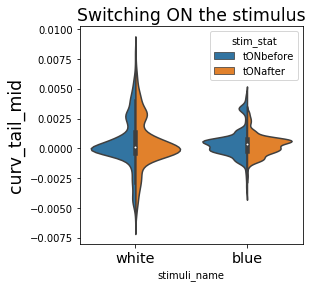

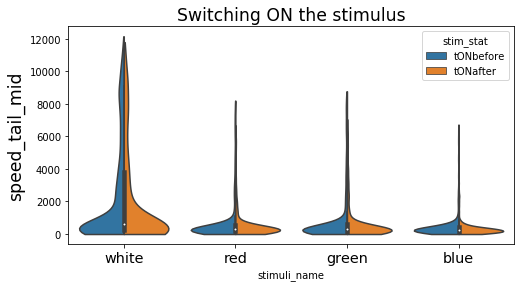

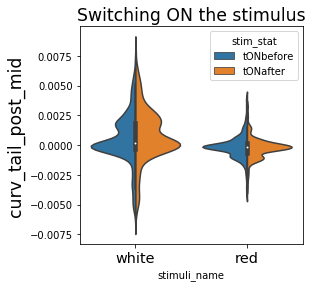

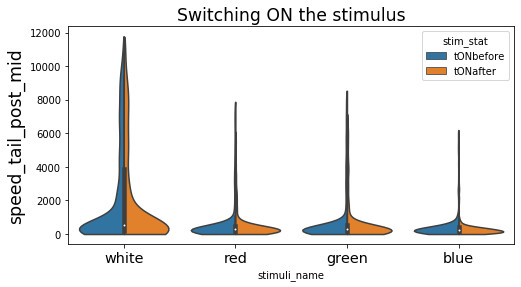

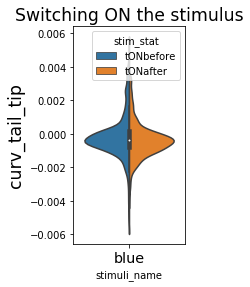

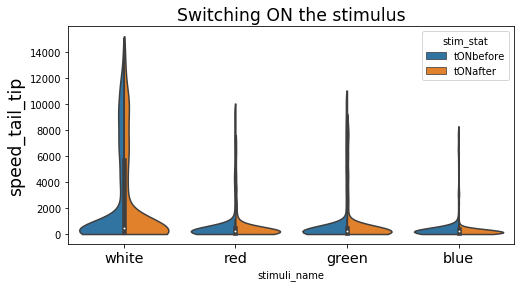

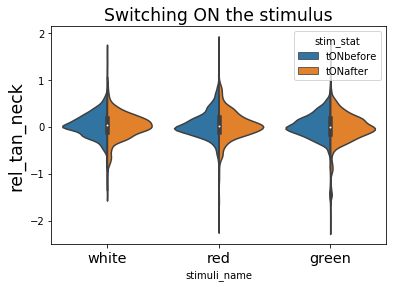

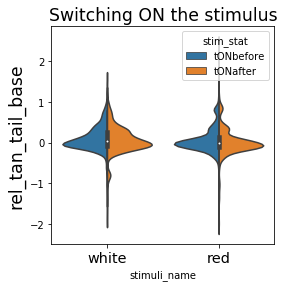

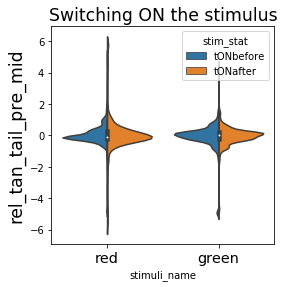

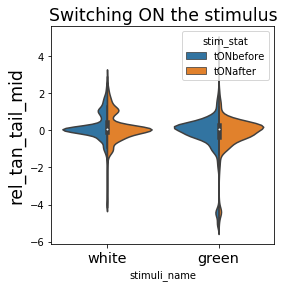

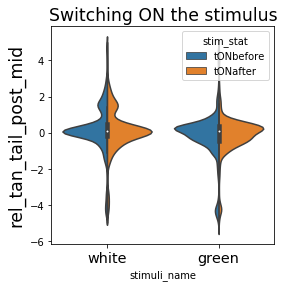

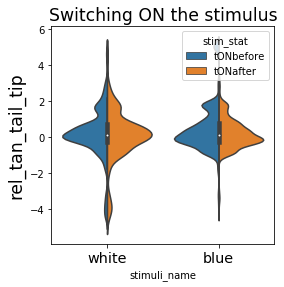

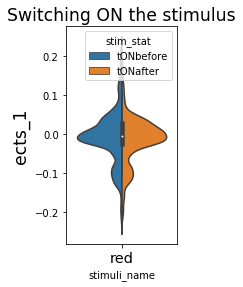

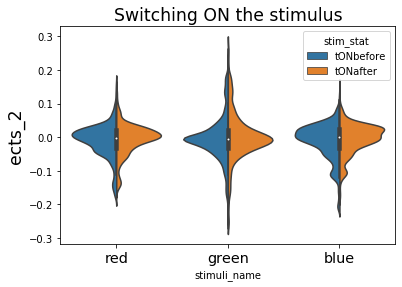

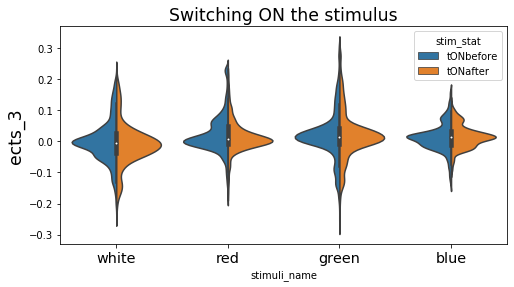

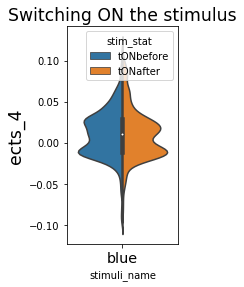

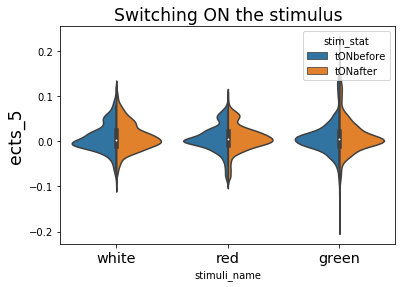

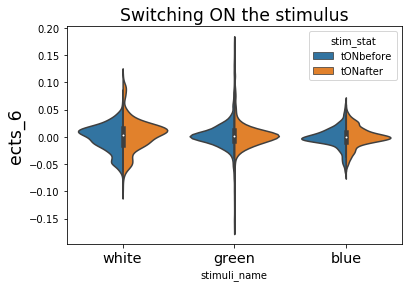

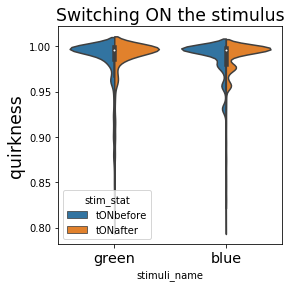

In [62]:
violin_height = 4

for i, param_dict in tqdm.tqdm(enumerate(param_dict_list_test1)):
    
    param = param_dict['param']
    
    if isinstance(param_dict['melted_on'], pd.DataFrame):
        n_sub = len(param_dict['melted_on'].stimuli_name.unique())
    
        fig, axes = plt.subplots(1, 1, figsize=(violin_height*(n_sub)/2,violin_height), sharey=True)
       
        if n_sub !=0:
            if 'speed' in param:
                sns.violinplot(data=param_dict['melted_on'], x='stimuli_name',y=param, hue='stim_stat', hue_order = ['tONbefore', 'tONafter'],
                                               split=True, scale="width", scale_hue=False, ax=axes, cut=0)
            else:
                sns.violinplot(data=param_dict['melted_on'], x='stimuli_name',y=param, hue='stim_stat', hue_order = ['tONbefore', 'tONafter'],
                                                   split=True, scale="width", scale_hue=False, ax=axes)
                
            axes.set_title('Switching ON the stimulus', size = 'xx-large')
            axes.set_xticklabels(axes.get_xticklabels(), size = 'x-large')
            axes.set_ylabel(param, size = 'xx-large')
            
            fig.savefig(os.path.join(dest_folder_oct18,f'test1_ON_{param}.svg'))

20it [00:02,  8.78it/s]<ipython-input-63-48e74bb9d864>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 1, figsize=(violin_height*(n_sub)/2,violin_height), sharey=True)
21it [00:02,  9.03it/s]<ipython-input-63-48e74bb9d864>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 1, figsize=(violin_height*(n_sub)/2,violin_height), sharey=True)
22it [00:02,  9.08it/s]<ipython-input-63-48e74bb9d864>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot inter

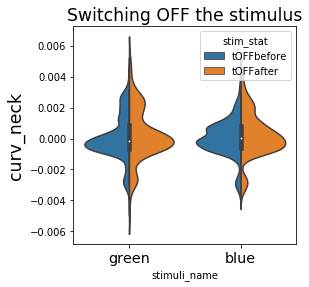

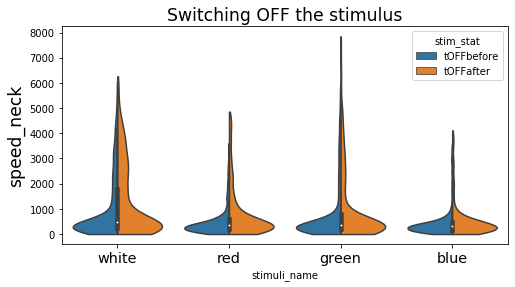

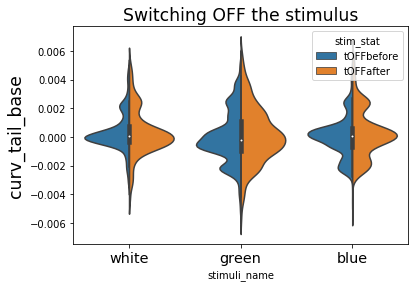

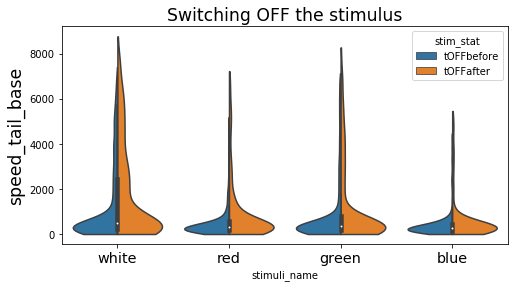

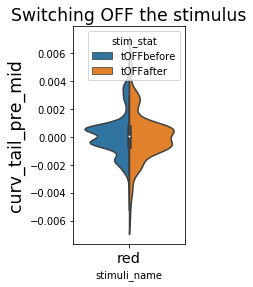

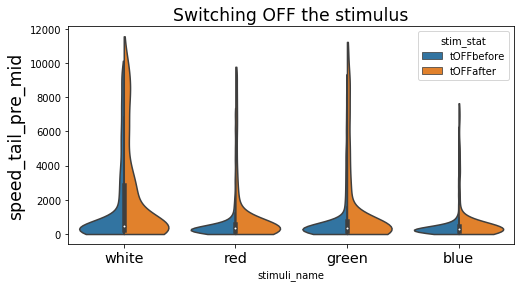

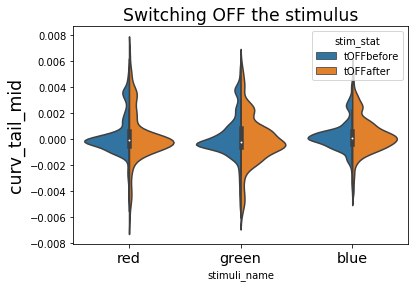

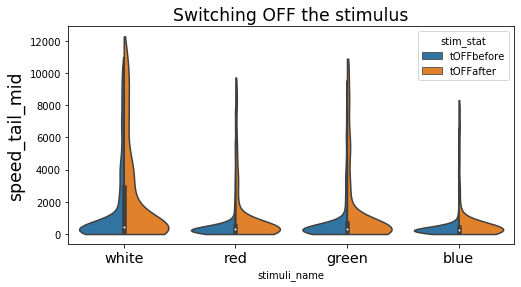

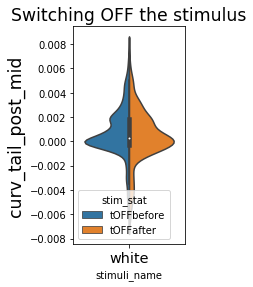

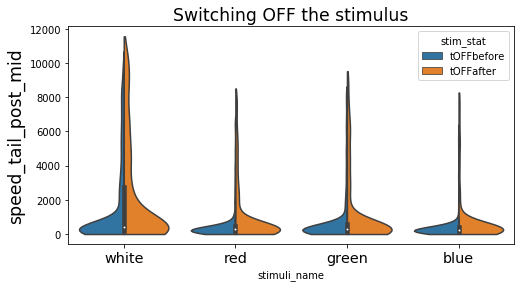

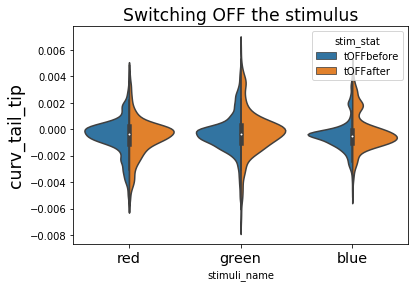

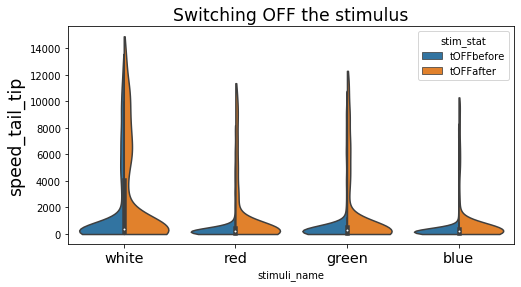

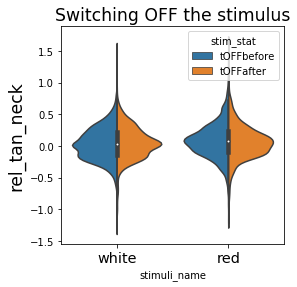

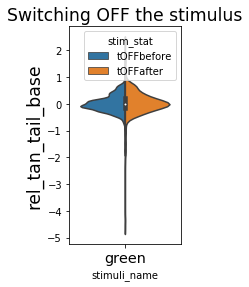

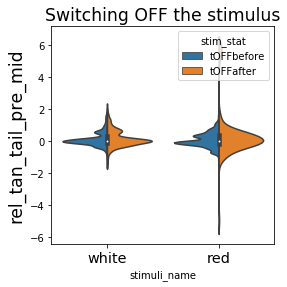

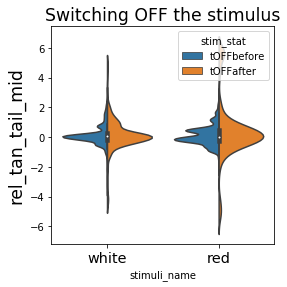

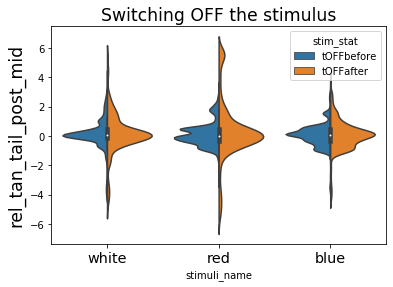

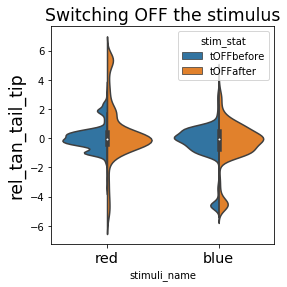

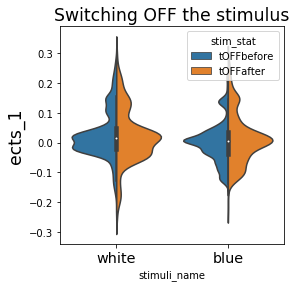

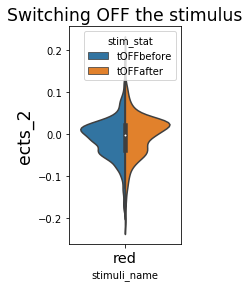

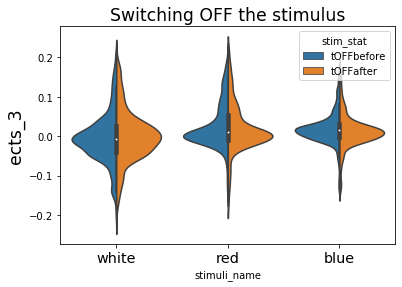

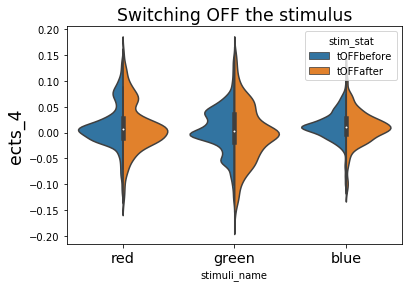

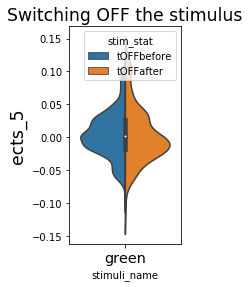

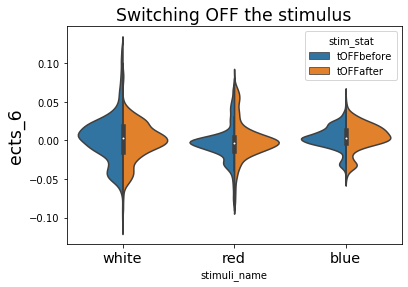

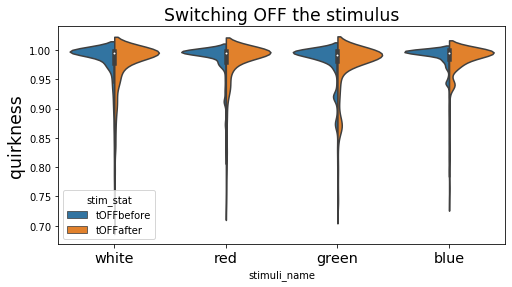

In [63]:
violin_height = 4

for i, param_dict in tqdm.tqdm(enumerate(param_dict_list_test1)):
    
    param = param_dict['param']
    
    if isinstance(param_dict['melted_off'], pd.DataFrame):
        n_sub = len(param_dict['melted_off'].stimuli_name.unique())
    
        fig, axes = plt.subplots(1, 1, figsize=(violin_height*(n_sub)/2,violin_height), sharey=True)
       
        if n_sub !=0:
            if 'speed' in param:
                sns.violinplot(data=param_dict['melted_off'], x='stimuli_name',y=param, hue='stim_stat', hue_order = ['tOFFbefore', 'tOFFafter'],
                                               split=True, scale="width", scale_hue=False, ax=axes, cut=0)
            else:
                sns.violinplot(data=param_dict['melted_off'], x='stimuli_name',y=param, hue='stim_stat', hue_order = ['tOFFbefore', 'tOFFafter'],
                                                   split=True, scale="width", scale_hue=False, ax=axes)
                
            axes.set_title('Switching OFF the stimulus', size = 'xx-large')
            axes.set_xticklabels(axes.get_xticklabels(), size = 'x-large')
            axes.set_ylabel(param, size = 'xx-large')
            
            fig.savefig(os.path.join(dest_folder_oct18,f'test1_OFF_{param}.svg'))

# Test 2 : Effect of drugs

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(data = df_light_drugs, x = 'drug', hue = 'stimuli_name', hue_order= stim_order, 
                   palette=stim_color_order)
ax.set_ylabel('Number of frames', size = 'x-large')
ax.set_xlabel('Drug', size = 'x-large')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -10), 
                   textcoords = 'offset points')
ax.set_title('Number of frames(samples) in the \n dataset for test2')
plt.savefig(f'./Figures/stats_light/stats_light_test2/test2_frames_ref.svg')

## mannwhitneyu for test2

In [ ]:
def mannwhitney_test2(drug, stimuli_name, params_list, _tail):
    
    pvalues_dict = {}
    pvalues_dict['stimuli_name'] = stimuli_name
    pvalues_dict['drug'] = drug
    
    df = df_light_drugs[(df_light_drugs['stimuli_name'] == stimuli_name)]
    
    if drug == 'Dopamine':
        control = 'AA'
    else:
        control = 'None'
    
    for param in params_list:
        
        
        results = mannwhitneyu(*[df[param][df["drug"] == group].values 
                         for group in [control,drug]], alternative= _tail)
        pvalues_dict[param] = results[-1]

    return pvalues_dict

In [ ]:
df_pval_stims_test2 = []

for stim in tqdm.tqdm(stim_order): 
    
    mwu_stim_test2 = Parallel(n_jobs= 3, verbose = 5)(delayed(mannwhitney_test2)(drug, stim, params_list,'two-sided') 
                                                          for drug in ['Fluoxetine', 'Dopamine', 'Serotonin'])
    df_pval_mwu_stim_test2 = pd.DataFrame(mwu_stim_test2)
    df_pval_stims_test2.append(df_pval_mwu_stim_test2)

df_pval_mwu_test2 = pd.concat(df_pval_stims_test2)

In [ ]:
df_pval_mwu_test2

In [ ]:
df_pval_mwu_test2.set_index(['stimuli_name','drug'], inplace = True)
df_pval_mwu_test2

In [ ]:
df_pval_mwu_test2.index

In [ ]:
df_binary_test2 = df_pval_mwu_test2[params_list] < 0.05

In [ ]:
df_binary_test2

In [ ]:
df_pval_mwu_test2.to_pickle('/share/devops/athira/ciona_tierpsy_behavior/Data/mwu_test_pvalues_light_test2.pickle')

## Make plots - test2

In [ ]:
def get_zscores_test2(param):

    df_param = df_light_drugs.groupby(['drug','stimuli_name','stim_stat'])[param].transform(lambda x: np.abs(stats.zscore(x, ddof=1)))
    
    return df_param

In [ ]:
df_zscores_test2 = Parallel(n_jobs=30, verbose = 5)(delayed(get_zscores_test2)(param) for param in params_list)

In [ ]:
df_combined_zscores_test2 = pd.concat(df_zscores_test2, axis = 1, keys=[f'{df.name}_zscore' for df in df_zscores_test2])
df_combined_zscores_test2

In [ ]:
df_light_zscores_test2 = pd.concat([df_light_drugs,df_combined_zscores_test2], axis=1)
df_light_zscores_test2

In [ ]:
df_binary_test2.index

In [ ]:
drug_stim_pairs = []
for drug in df_binary_test2.index.levels[1]:
    df_drug = df_light_drugs[df_light_drugs['drug'] == drug]
    
    drug_stim_pairs.extend([[drug, st] for st in list(df_drug.stimuli_name.unique())])
print(drug_stim_pairs)

In [ ]:
def make_a_melted_df_test2(main_df, param):
    
    list_to_melt = []
    params_df = main_df.filter(items=['stimuli_name', 'drug', param, f'{param}_zscore'])
    
    for drug_stim in drug_stim_pairs:
        
        drug = drug_stim[0]
        stim_name = drug_stim[1]
        
        if drug == 'Dopamine':
            control = 'AA'
        else :
            control = 'None'
        

        if df_binary_test2.loc[(stim_name, drug)][param]:
        
            # Select only those rows which are relevant to the particular light stimulus 
            stim_df = params_df[(params_df['stimuli_name']== stim_name)]
            # Select only those rows which are relevant to the drug test
            
            if drug in list(stim_df.drug.unique()):
                stim_event_df = stim_df[(stim_df['drug']==drug)|(stim_df['drug']==control)]
                stim_event_df['is_control'] = stim_event_df['drug'].apply(lambda x: 'control' if x==control else 'drug')
                stim_event_df['drug'] = drug
                # Select those rows which have an acceptable zscore
                stim_event_df = stim_event_df[stim_event_df[f'{param}_zscore'] < 3]
                stim_event_df.drop(columns=f'{param}_zscore', inplace=True)
                

                list_to_melt.append(stim_event_df)
    
    if list_to_melt:
        melted_param_df = pd.concat(list_to_melt)
        return melted_param_df      
    else:
        return param

In [ ]:

param_dict_list_test2 = Parallel(n_jobs= 30, verbose = 5)(delayed(make_a_melted_df_test2)(df_light_zscores_test2, param) for param in short_params_list)


In [ ]:
param_dict_list_test2[0].columns

In [ ]:
non_param_colnames  = ['drug','is_control', 'stimuli_name']

In [ ]:
short_params_list

In [ ]:
for i, param_df in tqdm.tqdm(enumerate(param_dict_list_test2)):
    
    if isinstance(param_df, pd.DataFrame):
        
        param = set(param_df.columns) ^ set(non_param_colnames)
        param = list(param)[0]

        n_stims = len(param_df.stimuli_name.unique())
        
        
#             max = 0
#             for stim in list(param_df.stimuli_name.unique()):
#                 n_drugs = len(param_df[param_df[stimuli_name]==stim].drug.unique())
#                 if n_drugs > 
                
                
        fig = plt.figure(figsize = (n_stims*3, 6))
        for i, stim in enumerate(param_df.stimuli_name.unique()):
            
            
            df_param_stim = param_df[param_df['stimuli_name'] == stim]
            
            n_drugs = len(df_param_stim.drug.unique())
            yrange = 2 * df_param_stim[param].max()-df_param_stim[param].min()
            xrange = n_drugs *2
            
            if i == 0:
                ax = fig.add_subplot(1,n_stims,i+1)
                ax1 = ax
            else:
                ax = fig.add_subplot(1,n_stims,i+1, sharey = ax1)
            
            if 'speed' in param:
                g = sns.violinplot(data = df_param_stim, x='drug',y=param, hue='is_control', hue_order = ['control', 'drug'],
                                               split=True, scale="width", scale_hue=False, ax = ax, cut = 0, legend=False)
            elif param == 'quirkness':
                g = sns.violinplot(data = df_param_stim, x='drug',y=param, hue='is_control', hue_order = ['control', 'drug'],
                                                   split=True, scale="width", scale_hue=False, ax = ax, cut =1, legend=False)
            else:
                g = sns.violinplot(data = df_param_stim, x='drug',y=param, hue='is_control', hue_order = ['control', 'drug'],
                                                   split=True, scale="width", scale_hue=False, ax = ax, legend=False)
            ax.set_title(stim)

            
            
        handles, labels = fig.get_axes()[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        
        for ax in fig.get_axes():
            ax.get_legend().remove()
            
        
            
        plt.tight_layout()
        fig.savefig(f'./Figures/stats_light/stats_light_test2/test2_{param}.svg')